# Antiderivative operator from an unaligned dataset

- https://github.com/lululxvi/deepxde

# Problem setup

We will learn the antiderivative operator
$$
G: v \mapsto u
$$
defined by an ODE
$$
\frac{du(x)}{dx} = v(x), \qquad x \in [0, 1],
$$
with IC `u(0)=0`.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
# PDE
geom = dde.geometry.TimeDomain(0, 1)


def pde(x, u, v):
    return dde.grad.jacobian(u, x) - v


ic = dde.icbc.IC(geom, lambda _: 0, lambda _, on_initial: on_initial)
pde = dde.data.PDE(geom, pde, ic, num_domain=20, num_boundary=2, num_test=40)

In [ ]:
# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
eval_pts = np.linspace(0, 1, num=50)[:, None]
data = dde.data.PDEOperator(pde, func_space, eval_pts, 1000, num_test=1000)

In [ ]:
# Net
net = dde.nn.DeepONet(
    [50, 128, 128, 128],
    [1, 128, 128, 128],
    "tanh",
    "Glorot normal",
)


# Hard constraint zero IC
def zero_ic(inputs, outputs):
    return outputs * inputs[1]


net.apply_output_transform(zero_ic)

model = dde.Model(data, net)

Compiling model...
'compile' took 0.749470 s

Training model...

Step      Train loss              Test loss               Test metric
0         [8.31e-01, 0.00e+00]    [8.13e-01, 0.00e+00]    []  
1000      [2.45e-02, 0.00e+00]    [2.52e-02, 0.00e+00]    []  
2000      [1.37e-02, 0.00e+00]    [1.30e-02, 0.00e+00]    []  
3000      [4.21e-03, 0.00e+00]    [4.33e-03, 0.00e+00]    []  
4000      [3.52e-03, 0.00e+00]    [3.57e-03, 0.00e+00]    []  
5000      [1.41e-03, 0.00e+00]    [1.46e-03, 0.00e+00]    []  
6000      [9.61e-04, 0.00e+00]    [1.05e-03, 0.00e+00]    []  
7000      [8.62e-04, 0.00e+00]    [9.21e-04, 0.00e+00]    []  
8000      [1.26e-03, 0.00e+00]    [1.32e-03, 0.00e+00]    []  
9000      [6.96e-04, 0.00e+00]    [7.53e-04, 0.00e+00]    []  
10000     [6.33e-04, 0.00e+00]    [6.65e-04, 0.00e+00]    []  
11000     [3.38e-04, 0.00e+00]    [3.53e-04, 0.00e+00]    []  
12000     [2.18e-04, 0.00e+00]    [2.53e-04, 0.00e+00]    []  
13000     [5.18e-04, 0.00e+00]    [5.73e-04, 0

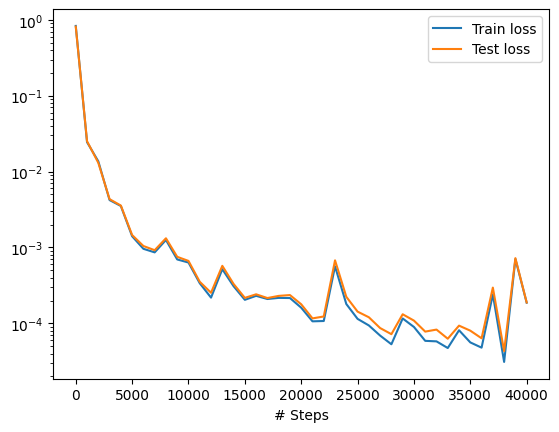

In [ ]:
# Training
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(iterations=40000)
dde.utils.plot_loss_history(losshistory)

0.00991703803763461


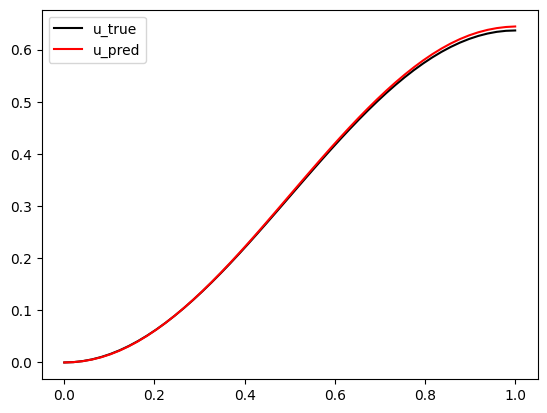

In [ ]:
x = np.linspace(0, 1, num=50)
v = np.sin(np.pi * x)
u = np.ravel(model.predict((np.tile(v, (50, 1)), x[:, None])))
u_true = 1 / np.pi - np.cos(np.pi * x) / np.pi
print(dde.metrics.l2_relative_error(u_true, u))

plt.figure()
plt.plot(x, u_true, "k", label="u_true")
plt.plot(x, u, "r", label="u_pred")
plt.legend()
plt.show()